# TetraVex Solver with PENNYLANE

In [2]:
from pennylane import qaoa
import pennylane as qml
from pennylane import numpy as np
from matplotlib import pyplot as plt
import networkx as nx

np.random.seed(42)

In [3]:
# Get the values & pieces from the TetraVex game
# Values are for visualization
# Pieces are for the algorithm
def getValuesAndPieces(file):
    north = []
    east = []
    south = []
    west = []
    pieces = {}
    i = 0
    for line in file:
        sides = line.split(" ")
        pieces[i] = [int(sides[0]), int(sides[1]), int(sides[2]), int(sides[3])]
        i += 1
        north.append([int(sides[0])])
        east.append([int(sides[1])])
        south.append([int(sides[2])])
        west.append([int(sides[3])])

    values = [north, east, south, west]
    print("values: " + str(values))
    print("pieces: " + str(pieces))
    return values, pieces

In [4]:
# Start board
sizeBoard = 2
file = open("./dataFiles/TetraVex_2x2.txt", "r")
values, pieces = getValuesAndPieces(file)

values: [[[8], [9], [1], [8]], [[9], [3], [8], [5]], [[1], [0], [1], [9]], [[4], [8], [8], [9]]]
pieces: {0: [8, 9, 1, 4], 1: [9, 3, 0, 8], 2: [1, 8, 1, 8], 3: [8, 5, 9, 9]}


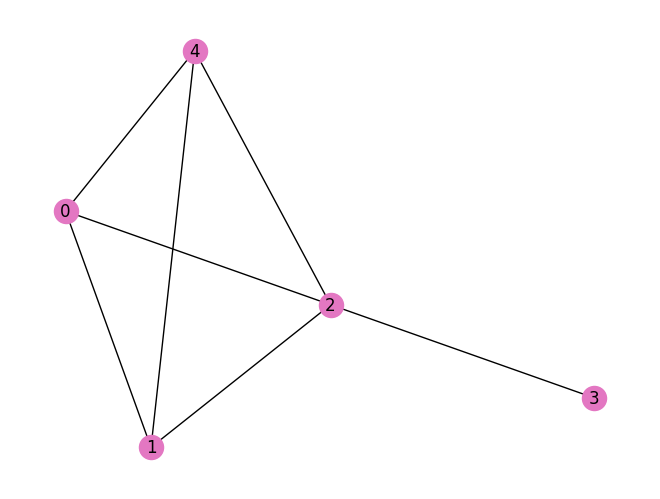

In [21]:
edges = [(0, 4), (4, 2), (2, 0), (2, 3), (1, 4), (1,0), (2,1)]
G = nx.Graph(edges)
nx.draw(G, with_labels=True, node_color="#e377c2")

In [6]:
cost_h, driver_h = qaoa.max_clique(G, constrained=False)

print("Cost Hamiltonian")
print(cost_h)
print("Driver Hamiltonian")
print(driver_h)

Cost Hamiltonian
  (-1.25) [Z3]
+ (0.25) [Z0]
+ (0.25) [Z4]
+ (0.25) [Z1]
+ (1.0) [Z2]
+ (0.75) [Z0 Z3]
+ (0.75) [Z4 Z3]
+ (0.75) [Z3 Z1]
Driver Hamiltonian
  (1) [X0]
+ (1) [X4]
+ (1) [X2]
+ (1) [X3]
+ (1) [X1]


In [7]:
def build_hamiltonian(graph):
    H = qml.Hamiltonian([], [])

    # Computes the complement of the graph
    graph_c = nx.complement(graph)

    for k in graph_c.nodes:
        # Adds the terms in the first sum
        for edge in graph_c.edges:
            i, j = edge
            if k == i:
                H += 6 * (qml.PauliY(k) @ qml.PauliZ(j) - qml.PauliY(k))
            if k == j:
                H += 6 * (qml.PauliZ(i) @ qml.PauliY(k) - qml.PauliY(k))
        # Adds the terms in the second sum
        H += 6 * qml.PauliY(k)

    return H


print("MaxClique Commutator")
print(build_hamiltonian(G))

MaxClique Commutator
  (-12.0) [Y3]
+ (6.0) [Y2]
+ (6.0) [Y0 Z3]
+ (6.0) [Y4 Z3]
+ (6.0) [Z0 Y3]
+ (6.0) [Z4 Y3]
+ (6.0) [Y3 Z1]
+ (6.0) [Z3 Y1]


In [8]:
def falqon_layer(beta_k, cost_h, driver_h, delta_t):
    qml.ApproxTimeEvolution(cost_h, delta_t, 1)
    qml.ApproxTimeEvolution(driver_h, delta_t * beta_k, 1)

In [9]:
def build_maxclique_ansatz(cost_h, driver_h, delta_t):
    def ansatz(beta, **kwargs):
        layers = len(beta)
        for w in dev.wires:
            qml.Hadamard(wires=w)
        qml.layer(
            falqon_layer,
            layers,
            beta,
            cost_h=cost_h,
            driver_h=driver_h,
            delta_t=delta_t
        )

    return ansatz

def expval_circuit(beta, measurement_h):
    ansatz = build_maxclique_ansatz(cost_h, driver_h, delta_t)
    ansatz(beta)
    return qml.expval(measurement_h)

In [10]:
def max_clique_falqon(graph, n, beta_1, delta_t, dev):
    comm_h = build_hamiltonian(graph) # Builds the commutator
    cost_h, driver_h = qaoa.max_clique(graph, constrained=False) # Builds H_c and H_d
    cost_fn = qml.QNode(expval_circuit, dev, interface="autograd") # The ansatz + measurement circuit is executable

    beta = [beta_1] # Records each value of beta_k
    energies = [] # Records the value of the cost function at each step

    for i in range(n):
        # Adds a value of beta to the list and evaluates the cost function
        beta.append(-1 * cost_fn(beta, measurement_h=comm_h))  # this call measures the expectation of the commuter hamiltonian
        energy = cost_fn(beta, measurement_h=cost_h)  # this call measures the expectation of the cost hamiltonian
        energies.append(energy)

    return beta, energies

In [11]:
n = 40
beta_1 = 0.0
delta_t = 0.03

dev = qml.device("default.qubit", wires=G.nodes) # Creates a device for the simulation
res_beta, res_energies = max_clique_falqon(G, n, beta_1, delta_t, dev)

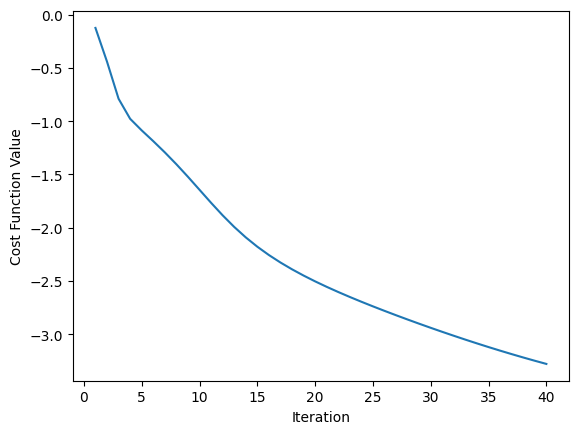

In [12]:
plt.plot(range(n+1)[1:], res_energies)
plt.xlabel("Iteration")
plt.ylabel("Cost Function Value")
plt.show()

In [13]:
@qml.qnode(dev, interface="autograd")
def prob_circuit():
    ansatz = build_maxclique_ansatz(cost_h, driver_h, delta_t)
    ansatz(res_beta)
    return qml.probs(wires=dev.wires)

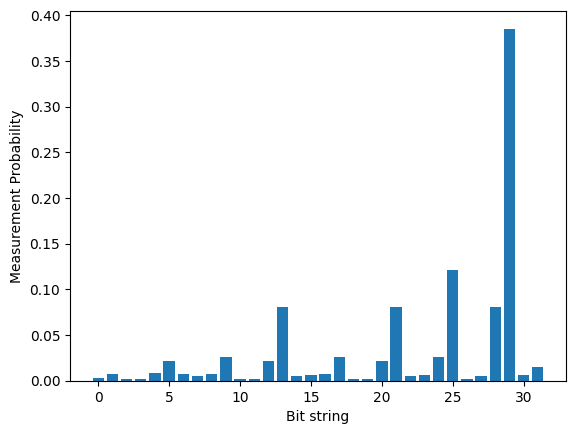

In [14]:
probs = prob_circuit()
plt.bar(range(2**len(dev.wires)), probs)
plt.xlabel("Bit string")
plt.ylabel("Measurement Probability")
plt.show()

In [15]:
def get_highest_probability_bitstring(probs):
    max_index = np.argmax(probs)
    num_wires = G.number_of_nodes()

    bitstring = [0] * num_wires

    for i in range(num_wires):
        bitstring[i] = max_index % 2
        max_index //= 2

    bitstring = bitstring[::-1]
    return bitstring

# Bitstring with the order of the nodes: 0, 1, 2, 3
highest_prob_bitstring = get_highest_probability_bitstring(probs)
print("Int highest probability:", np.argmax(probs))
print("Bitstring with highest probability:", highest_prob_bitstring)


Int highest probability: 29
Bitstring with highest probability: [1, 1, 1, 0, 1]


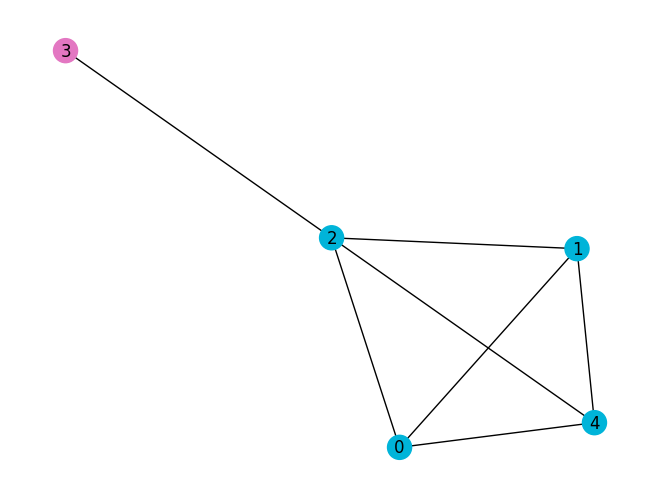

In [23]:
graph = nx.Graph(edges)
cmap = ["#00b4d9"]*3 + ["#e377c2"]*1 + ["#00b4d9"]
nx.draw(G, with_labels=True, node_color=cmap)

## Combination of QAOA and FALQON

Graaf aanpassen zodat elke vertex geschreven wordt als XY met X de positie en Y welk puzzelstuk
Vervolgens omzetten naar een bitstring: integer stelt een positie voor in de bitstring
In bitstring 1 wil zeggen dat de positie&puzzelstuk oplossing is

### Graaf voorstelling
XY vertex nummer
X positie puzzelstuk 
    0 1
    2 3

Y welk puzzelstuk 0 - 3

(0, 0): [(3, 1), (2, 2), (3, 2), (1, 3), (3, 3)]
(1, 0): [(2, 1), (2, 2), (3, 2), (2, 3)]
(2, 0): [(1, 1), (1, 2), (1, 3), (3, 3)]
(3, 0): [(0, 1), (0, 2), (0, 3)]
(0, 1): [(3, 0), (3, 2), (3, 3)]
(1, 1): [(2, 0), (0, 2), (2, 2), (2, 3)]
(2, 1): [(1, 0), (1, 2), (0, 3), (1, 3)]
(3, 1): [(0, 0), (0, 2), (2, 2), (0, 3), (1, 3)]
(0, 2): [(3, 0), (1, 1), (3, 1), (3, 3)]
(1, 2): [(2, 0), (2, 1), (2, 3)]
(2, 2): [(0, 0), (1, 0), (1, 1), (3, 1), (1, 3)]
(3, 2): [(0, 0), (1, 0), (0, 1), (0, 3)]
(0, 3): [(3, 0), (2, 1), (3, 1), (3, 2)]
(1, 3): [(0, 0), (2, 0), (2, 1), (3, 1), (2, 2)]
(2, 3): [(1, 0), (1, 1), (1, 2)]
(3, 3): [(0, 0), (2, 0), (0, 1), (0, 2)]


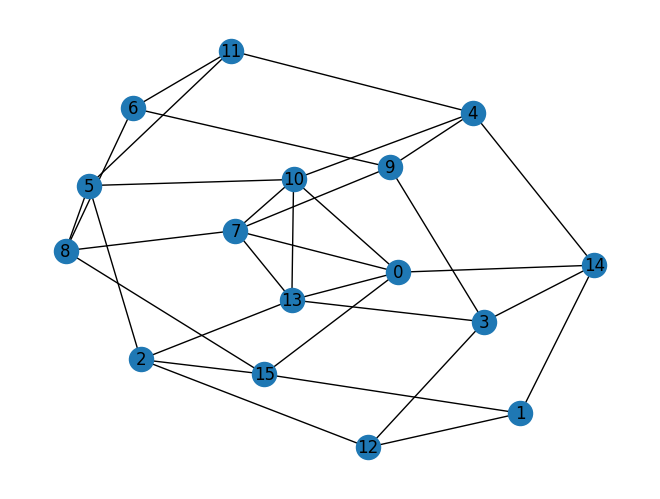

Cliques Iterative - NX: 
[0, 7, 10, 13]


In [32]:
# Build Graph
size = len(pieces)
graph = {}
for piece1, colors1 in pieces.items():
    for row1 in range(sizeBoard):
        for col1 in range(sizeBoard):
            for piece2, colors2 in pieces.items():
                if piece1 == piece2:
                        continue
                for row2 in range(sizeBoard):
                    for col2 in range(sizeBoard): 
                        if row1 == row2 and col1 == col2:
                            continue
                        position1 = row1*sizeBoard + col1
                        position2 = row2*sizeBoard + col2
                        node1 = (position1, piece1)
                        node2 = (position2, piece2)

                        graph.setdefault(node1, []).append(node2)

                        if row1-1 == row2 and col1 == col2 \
                            and colors1[0] != colors2[2]:
                                graph[node1].remove(node2)

                        if row1 == row2-1 and col1 == col2 \
                            and colors1[2] != colors2[0]:
                                graph[node1].remove(node2)

                        if row1 == row2 and col1-1 == col2 \
                            and colors1[3] != colors2[1]:
                                graph[node1].remove(node2)   

                        if row1 == row2 and col1 == col2-1 \
                            and colors1[1] != colors2[3]:
                                graph[node1].remove(node2) 

for node, edges in graph.items():
    print(str(node) + ": " + str(edges))
G = nx.Graph()
for node, edges in graph.items():
    for edge in edges:
        # nodeStr = int(str(node[0]) + str(node[1]))
        nodeStr = int(node[0]*4 + node[1])
        edgeStr =  int(edge[0]*4 + edge[1])
        G.add_edge(nodeStr, edgeStr)
nx.draw(G, with_labels = True)
plt.show()

# Networkx - All Cliques Iterative
res = nx.find_cliques(G)
cliques = [item for item in res]
cliques = sorted(cliques, key=lambda item: -len(item))
print("Cliques Iterative - NX: ")
for item in cliques:
    if(len(item) == sizeBoard*sizeBoard):
        print(item)
        break

## Oplossing

Oplossing zou moeten zijn **9345** of **33060**

In [25]:
depth = 5
dev = qml.device("default.qubit", wires=G.nodes)

# Creates the cost and mixer Hamiltonians
cost_h, mixer_h = qaoa.max_clique(G, constrained=False)

# Creates a layer of QAOA
def qaoa_layer(gamma, beta):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(beta, mixer_h)

# Creates the full QAOA circuit as an executable cost function
def qaoa_circuit(params, **kwargs):
    for w in dev.wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[0], params[1])


@qml.qnode(dev, interface="autograd")
def qaoa_expval(params):
    qaoa_circuit(params)
    return qml.expval(cost_h)

In [26]:
delta_t = 0.02

res, res_energy = max_clique_falqon(G, depth-1, 0.0, delta_t, dev)

params = np.array([[delta_t for k in res], [delta_t * k for k in res]], requires_grad=True)

In [27]:
steps = 40

optimizer = qml.GradientDescentOptimizer()

for s in range(steps):
    params, cost = optimizer.step_and_cost(qaoa_expval, params)
    print("Step {}, Cost = {}".format(s + 1, cost))

Step 1, Cost = 86.92581808693662
Step 2, Cost = 0.5224705403538163
Step 3, Cost = 0.18646379456705814
Step 4, Cost = -0.775702823937141
Step 5, Cost = -2.7000020466906225
Step 6, Cost = 45.96193686074768
Step 7, Cost = 0.6041507111543845
Step 8, Cost = -0.26855758963405946
Step 9, Cost = 1.135308416316846
Step 10, Cost = -0.1905784314145326
Step 11, Cost = -0.039782073664797385
Step 12, Cost = 0.060120022577448425
Step 13, Cost = 0.5611529111589196
Step 14, Cost = 0.1344224726125008
Step 15, Cost = 0.2522846927440815
Step 16, Cost = -0.38578102304571504
Step 17, Cost = -0.17964980634926536
Step 18, Cost = 0.10412115047935212
Step 19, Cost = 0.23622251070362638
Step 20, Cost = -0.04079873605301675
Step 21, Cost = 0.04964471000093745
Step 22, Cost = 1.0953029065891124
Step 23, Cost = 0.1198329833748865
Step 24, Cost = 0.4509275280958509
Step 25, Cost = 0.34716553386518056
Step 26, Cost = -0.0753620809742852
Step 27, Cost = 0.3723415868563825
Step 28, Cost = 0.15618680349589567
Step 29, C

In [28]:
@qml.qnode(dev, interface="autograd")
def prob_circuit(params):
    qaoa_circuit(params)
    return qml.probs(wires=dev.wires)

probs = prob_circuit(params)

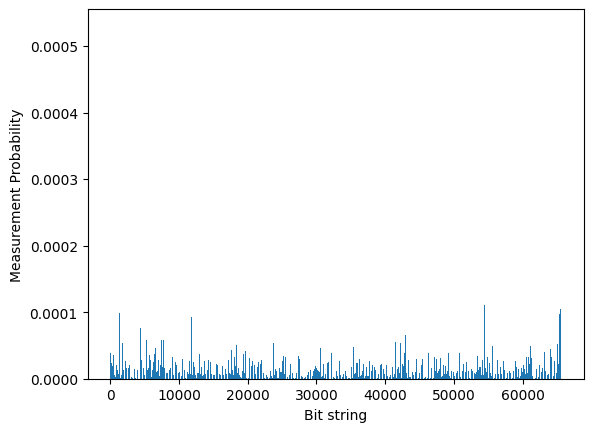

In [33]:
plt.bar(range(2**len(dev.wires)), probs)
plt.xlabel("Bit string")
plt.ylabel("Measurement Probability")
plt.show()

In [29]:
def get_highest_probability_bitstring(probs):
    max_index = np.argmax(probs)
    num_wires = G.number_of_nodes()

    bitstring = [0] * num_wires

    for i in range(num_wires):
        bitstring[i] = max_index % 2
        max_index //= 2

    bitstring = bitstring[::-1]
    return bitstring

# Bitstring with the order of the nodes: 0, 1, 2, 3
highest_prob_bitstring = get_highest_probability_bitstring(probs)
print("Int highest probability:", np.argmax(probs))
print("Bitstring with highest probability:", highest_prob_bitstring)

Int highest probability: 5987
Bitstring with highest probability: [0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1]


In [30]:
node = 0
for i in highest_prob_bitstring:
    if i == 1:
        print("Node: " + str(node) + " is in the max clique")
    node+=1

Node: 3 is in the max clique
Node: 5 is in the max clique
Node: 6 is in the max clique
Node: 7 is in the max clique
Node: 9 is in the max clique
Node: 10 is in the max clique
Node: 14 is in the max clique
Node: 15 is in the max clique
